# VAE Analysis - Faces dataset

## imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm
import pandas as pd

from models.VAE import VariationalAutoencoder
from utils.loaders import load_model, ImageLabelLoader

In [2]:
# run params
section = 'vae'
run_id = '0001'
data_name = 'faces'
RUN_FOLDER = 'run/{}/'.format(section)
RUN_FOLDER += '_'.join([run_id, data_name])


DATA_FOLDER = './data/celeb/'
IMAGE_FOLDER = './data/celeb/img_align_celeba/'

## data

In [3]:
INPUT_DIM = (128,128,3)

att = pd.read_csv(os.path.join(DATA_FOLDER, 'list_attr_celeba.csv'))

imageLoader = ImageLabelLoader(IMAGE_FOLDER, INPUT_DIM[:2])


In [4]:
att.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


## architecture

In [ ]:
vae = load_model(VariationalAutoencoder, RUN_FOLDER)

## reconstructing faces

We can see that the VAE has successfully captured the key features of each face—the angle of the head, the hairstyle, the expression, etc. Some of the fine detail is missing, but it is important to remember that the aim of building variational autoencoders isn’t to achieve perfect reconstruction loss. Our end goal is to sample from the latent space in order to generate new faces.

Found 202599 images.


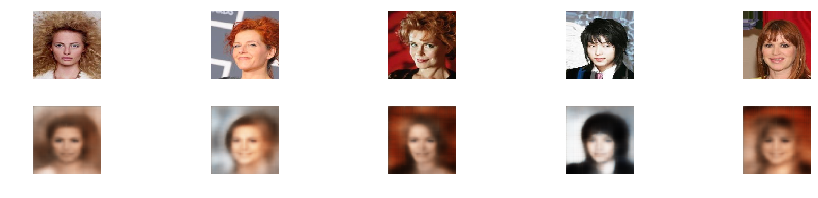

In [6]:
n_to_show = 5
#We sample 5 points from a standard normal distribution with 200 dimensions…
data_flow_generic = imageLoader.build(att, n_to_show)

example_batch = next(data_flow_generic)
example_images = example_batch[0]
#pass 5 points to the decoder.
z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')        
    sub.imshow(img)

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    #The resulting output is a 128 × 128 × 3 image that we can view.
    sub.imshow(img)
    #Here is a sample of reconstructed faces. The top row shows the original images and the bottom row shows the reconstructions
    #once they have passed through the encoder and decoder.
    #We can see that the VAE has successfully captured the key features of each face—the angle of the head, the hairstyle(number 4 image or 5), the expression, etc. 
    #Some of the fine detail is missing, but it is important to remember that the aim of building variational autoencoders isn’t to achieve perfect reconstruction loss.
    #Our end goal is to sample from the latent space in order to generate new faces


## Latent space distribution

we must check that the distribution of points in the latent space approximately resembles a multivariate standard normal distribution. Since we cannot view all dimensions simultaneously, we can instead check the distribution of each latent dimension individually. If we see any dimensions that are significantly different from a standard normal distribution, we should probably reduce the reconstruction loss factor, since the KL divergence term isn’t having enough effect.

20/20 [==============================] - 19s 935ms/step


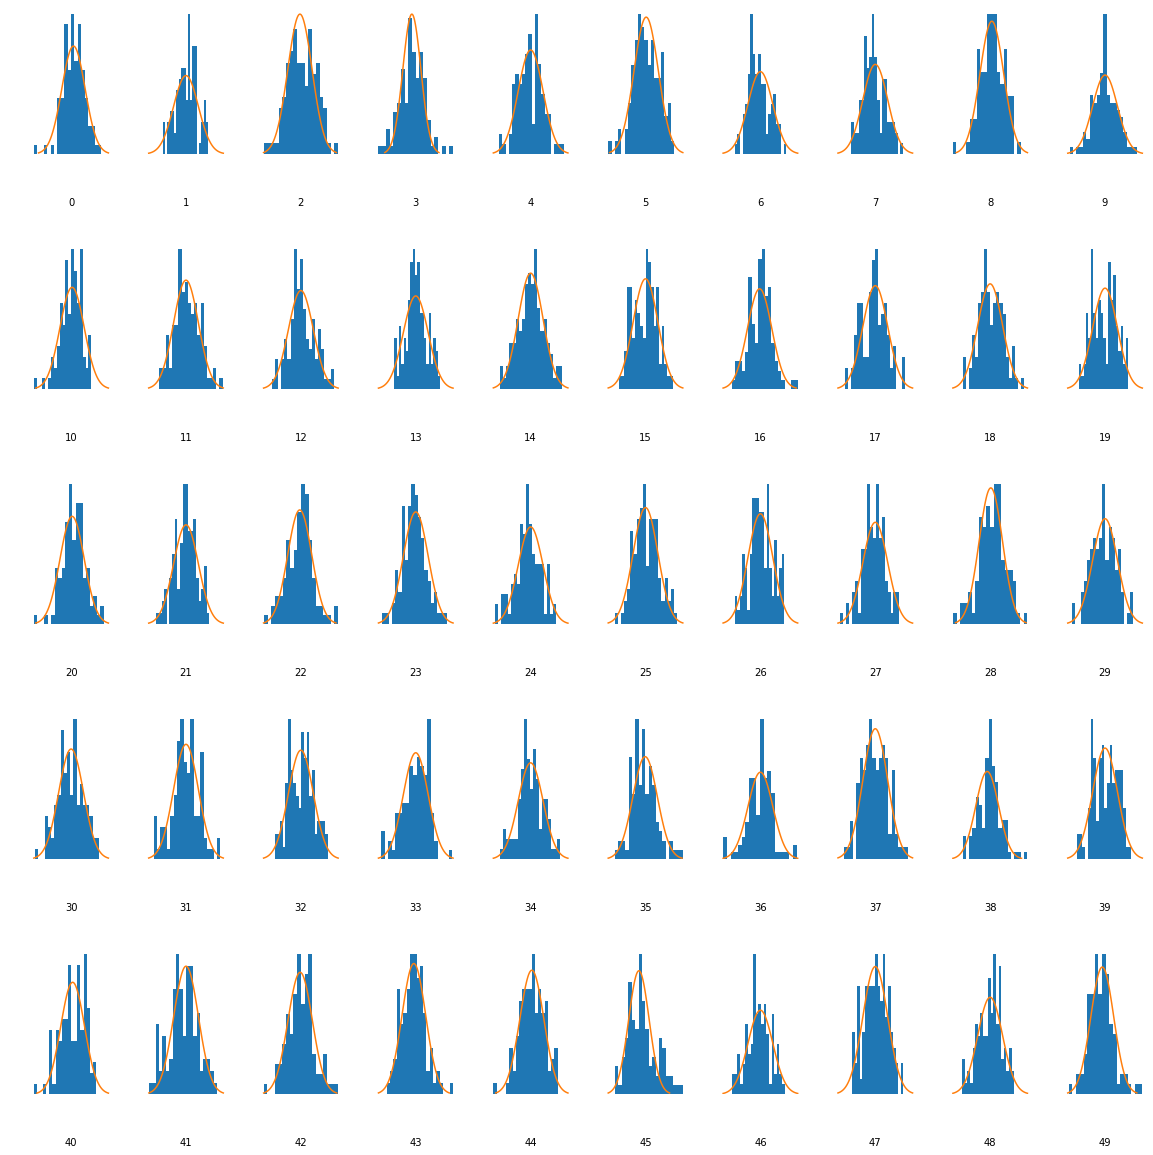

In [7]:
z_test = vae.encoder.predict_generator(data_flow_generic, steps = 20, verbose = 1)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()

### Newly generated faces

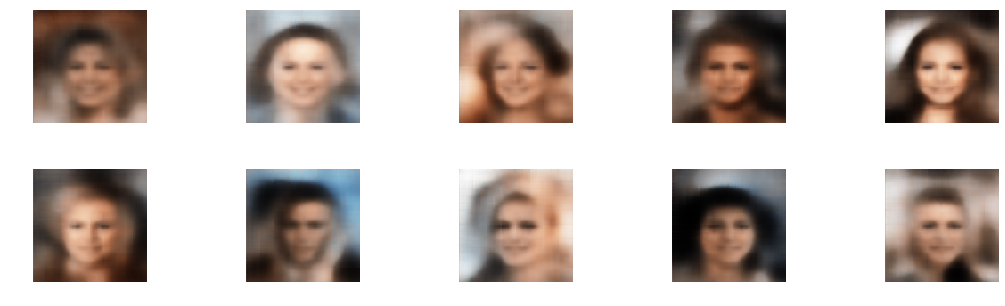

In [8]:
n_to_show = 10

znew = np.random.normal(size = (n_to_show,vae.z_dim))

reconst = vae.decoder.predict(np.array(znew))

fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_show):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(reconst[i, :,:,:])
    ax.axis('off')

plt.show()
#Amazingly, the VAE is able to take the set of points that we sampled and convert each into a convincing image of a person’s face. While the images are not perfect, they are a giant leap forward from the Naive Bayes model.
#The Naive Bayes model faced the problem of not being able to capture dependency between adjacent pixels
#the convolutional layers of the encoder are designed to translate low-level pixels into high-level features and the decoder is trained to perform the opposite task of translating the high-level features in the latent space back to raw pixels.

### Latent Space Arithmetic
One benefit of mapping images into a lower-dimensional space is that we can perform arithmetic on vectors in this latent space that has a visual analogue when decoded back into the original image domain.

In [9]:
def get_vector_from_label(label, batch_size):

    data_flow_label = imageLoader.build(att, batch_size, label = label)

    origin = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_sum_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_POS = 0
    current_mean_POS = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_sum_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape = vae.z_dim, dtype = 'float32')

    current_vector = np.zeros(shape = vae.z_dim, dtype = 'float32')
    current_dist = 0

    print('label: ' + label)
    print('images : POS move : NEG move :distance : 𝛥 distance')
    while(current_n_POS < 10000):

        batch = next(data_flow_label)
        im = batch[0]
        attribute = batch[1]

        z = vae.encoder.predict(np.array(im))

        z_POS = z[attribute==1]
        z_NEG = z[attribute==-1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis = 0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS-current_mean_POS)

        if len(z_NEG) > 0: 
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis = 0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG-current_mean_NEG)

        current_vector = new_mean_POS-new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist


        print(str(current_n_POS)
              + '    : ' + str(np.round(movement_POS,3))
              + '    : ' + str(np.round(movement_NEG,3))
              + '    : ' + str(np.round(new_dist,3))
              + '    : ' + str(np.round(dist_change,3))
             )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print('Found the ' + label + ' vector')
            break

    return current_vector   


In [10]:
def add_vector_to_images(feature_vec):

    n_to_show = 5
    factors = [-4,-3,-2,-1,0,1,2,3,4]

    example_batch = next(data_flow_generic)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):

        img = example_images[i].squeeze()
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis('off')        
        sub.imshow(img)

        counter += 1

        for factor in factors:

            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

            img = changed_image.squeeze()
            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis('off')
            sub.imshow(img)

            counter += 1

    plt.show()


In [11]:
BATCH_SIZE = 500
attractive_vec = get_vector_from_label('Attractive', BATCH_SIZE)
mouth_open_vec = get_vector_from_label('Mouth_Slightly_Open', BATCH_SIZE)
smiling_vec = get_vector_from_label('Smiling', BATCH_SIZE)
lipstick_vec = get_vector_from_label('Wearing_Lipstick', BATCH_SIZE)
young_vec = get_vector_from_label('High_Cheekbones', BATCH_SIZE)
male_vec = get_vector_from_label('Male', BATCH_SIZE)

Found 202599 images.
label: Attractive
images : POS move : NEG move :distance : 𝛥 distance
251    : 1.258    : 1.096    : 1.522    : 1.522
499    : 0.596    : 0.594    : 1.29    : -0.232
762    : 0.372    : 0.331    : 1.256    : -0.034
1029    : 0.243    : 0.293    : 1.247    : -0.009
1275    : 0.198    : 0.2    : 1.213    : -0.034
1538    : 0.162    : 0.172    : 1.182    : -0.031
1789    : 0.143    : 0.136    : 1.191    : 0.009
2053    : 0.111    : 0.113    : 1.161    : -0.03
2314    : 0.105    : 0.096    : 1.162    : 0.001
2567    : 0.088    : 0.099    : 1.16    : -0.003
2823    : 0.086    : 0.089    : 1.165    : 0.005
3084    : 0.075    : 0.074    : 1.169    : 0.004
3342    : 0.072    : 0.071    : 1.177    : 0.008
3607    : 0.063    : 0.061    : 1.157    : -0.02
3876    : 0.062    : 0.056    : 1.154    : -0.002
4106    : 0.055    : 0.061    : 1.162    : 0.007
4338    : 0.054    : 0.056    : 1.163    : 0.001
4594    : 0.052    : 0.057    : 1.164    : 0.001
4849    : 0.046    : 0.045 

In [12]:
eyeglasses_vec = get_vector_from_label('Eyeglasses', BATCH_SIZE)

Found 202599 images.
label: Eyeglasses
images : POS move : NEG move :distance : 𝛥 distance
33    : 3.154    : 0.929    : 3.263    : 3.263
60    : 1.773    : 0.487    : 2.581    : -0.682
96    : 1.195    : 0.26    : 2.307    : -0.274
124    : 0.682    : 0.206    : 2.227    : -0.08
168    : 0.719    : 0.146    : 2.106    : -0.121
196    : 0.431    : 0.123    : 2.043    : -0.062
220    : 0.334    : 0.108    : 2.018    : -0.025
254    : 0.353    : 0.088    : 1.973    : -0.046
279    : 0.242    : 0.076    : 1.941    : -0.032
308    : 0.272    : 0.068    : 1.906    : -0.035
346    : 0.302    : 0.07    : 1.859    : -0.046
380    : 0.242    : 0.059    : 1.811    : -0.049
416    : 0.222    : 0.054    : 1.786    : -0.025
443    : 0.182    : 0.052    : 1.786    : -0.0
471    : 0.159    : 0.044    : 1.788    : 0.003
498    : 0.155    : 0.045    : 1.765    : -0.024
534    : 0.16    : 0.042    : 1.736    : -0.028
568    : 0.156    : 0.035    : 1.745    : 0.009
600    : 0.132    : 0.035    : 1.715   

In [13]:
blonde_vec = get_vector_from_label('Blond_Hair', BATCH_SIZE)

Found 202599 images.
label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
79    : 2.308    : 0.954    : 2.634    : 2.634
154    : 1.033    : 0.519    : 2.365    : -0.269
227    : 0.607    : 0.27    : 2.196    : -0.169
305    : 0.459    : 0.193    : 2.146    : -0.05
391    : 0.39    : 0.163    : 2.064    : -0.082
465    : 0.274    : 0.127    : 2.052    : -0.012
547    : 0.235    : 0.103    : 2.013    : -0.039
617    : 0.186    : 0.092    : 2.026    : 0.013
696    : 0.197    : 0.081    : 2.032    : 0.006
761    : 0.162    : 0.079    : 2.037    : 0.005
824    : 0.138    : 0.065    : 2.012    : -0.025
895    : 0.126    : 0.061    : 2.007    : -0.006
966    : 0.118    : 0.056    : 2.009    : 0.003
1046    : 0.115    : 0.05    : 2.004    : -0.005
1131    : 0.124    : 0.045    : 1.994    : -0.01
1205    : 0.104    : 0.039    : 1.993    : -0.001
1285    : 0.105    : 0.042    : 2.007    : 0.014
1367    : 0.092    : 0.038    : 2.011    : 0.004
1451    : 0.098    : 0.037    : 2.0

Eyeglasses Vector


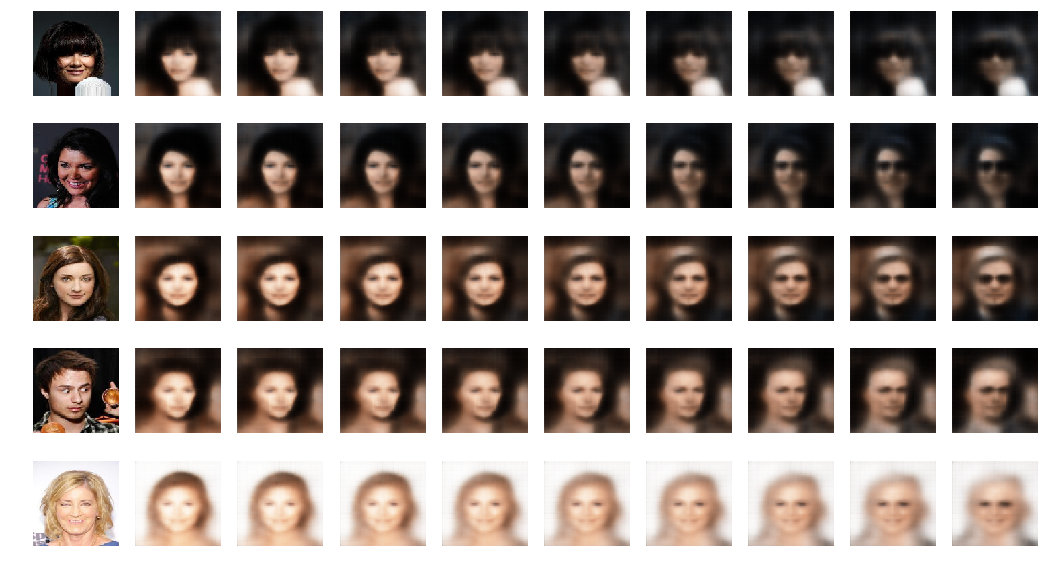

In [14]:
# print('Attractive Vector')
# add_vector_to_images(attractive_vec)

# print('Mouth Open Vector')
# add_vector_to_images(mouth_open_vec)

# print('Smiling Vector')
# add_vector_to_images(smiling_vec)

# print('Lipstick Vector')
# add_vector_to_images(lipstick_vec)

# print('Young Vector')
# add_vector_to_images(young_vec)

# print('Male Vector')
# add_vector_to_images(male_vec)

#shows several images that have been encoded into the latent space. 
#We then add or subtract multiples of a eyeglasses vector to obtain different versions of the image,
#with only the relevant feature changed.
#So the goal was having image of the same person with eyeglassess.
print('Eyeglasses Vector')
add_vector_to_images(eyeglasses_vec)

# print('Blond Vector')
# add_vector_to_images(blonde_vec)

So how can we find the Eyeglasses vector? Each image in the CelebA dataset is labeled with attributes, one of which is Eyeglasses. If we take the average position of encoded images in the latent space with the attribute Eyeglasses and subtract the average position of encoded images that do not have the attribute Eyeglasses, we will obtain the vector that points from not Eyeglasses to Eyeglasses, which is exactly what we need.

Conceptually, we are performing the following vector arithmetic in the latent space, where alpha is a factor that determines how much of the feature vector is added or subtracted:

z_new = z + alpha * feature_vector

In [15]:

def morph_faces(start_image_file, end_image_file):

    factors = np.arange(0,1,0.1)

    att_specific = att[att['image_id'].isin([start_image_file, end_image_file])]
    att_specific = att_specific.reset_index()
    data_flow_label = imageLoader.build(att_specific, 2)

    example_batch = next(data_flow_label)
    example_images = example_batch[0]
    example_labels = example_batch[1]

    z_points = vae.encoder.predict(example_images)


    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)

    counter+=1


    for factor in factors:

        changed_z_point = z_points[0] * (1-factor) + z_points[1]  * factor
        changed_image = vae.decoder.predict(np.array([changed_z_point]))[0]

        img = changed_image.squeeze()
        sub = fig.add_subplot(1, len(factors)+2, counter)
        sub.axis('off')
        sub.imshow(img)

        counter += 1

    img = example_images[1].squeeze()
    sub = fig.add_subplot(1, len(factors)+2, counter)
    sub.axis('off')        
    sub.imshow(img)


    plt.show()

In order to morgh between two faces assume two points in the latent space, A and B, that represent two images. If you started at point A and walked toward point B in a straight line, decoding each point on the line as you went, you would see a gradual transition from the starting face to the end face.

Mathematically, we are traversing a straight line, which can be described by the following equation:

z_new = z_A * (1- alpha) + z_B * alpha

Here, alpha is a number between 0 and 1 that determines how far along the line we are, away from point A.

Found 2 images.


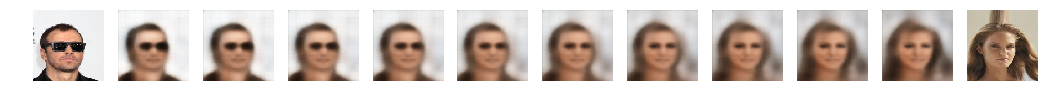

In [16]:
start_image_file = '000238.jpg' 
end_image_file = '000193.jpg' #glasses

morph_faces(start_image_file, end_image_file)

Found 2 images.


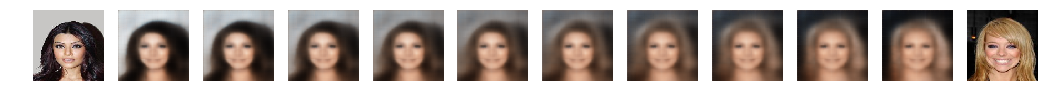

In [17]:
start_image_file = '000112.jpg'
end_image_file = '000258.jpg'

morph_faces(start_image_file, end_image_file)

Found 2 images.


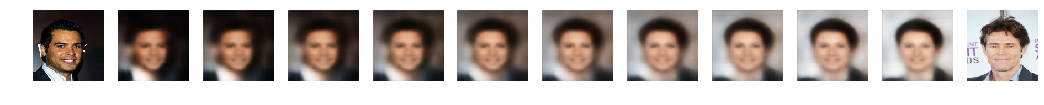

In [18]:
start_image_file = '000230.jpg'
end_image_file = '000712.jpg'

morph_faces(start_image_file, end_image_file)